# Comparing the analytical expression of $(\Delta N/\Delta T)_i$ to the Super-K Monte Carlo detector model

This notebook contains a short tutorial for generating the spectrum of scattered electrons in Super-K due to $^8$B neutrinos, in the absence of neutrino mixing $(P_{\nu_e} (E) = 1)$. This spectrum serves as a comparison of the analytical expression shown in our paper to the Super-K in-house model of their detector.

In [1]:
import solarLMAO as sLMAO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from astropy import constants as const
from astropy import units as u
import scipy as sp
import inspect

In [2]:
cm = plt.get_cmap('jet')
plt.style.use('style_prof2.mplstyle')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

default_size = 18
plt.rcParams.update({
    'font.size': default_size,  # This sets the default font size for everything
    'font.weight': 'bold',
    'axes.titlesize': default_size,
    'axes.labelsize': default_size,
    'xtick.labelsize': default_size,
    'ytick.labelsize': default_size,
    'legend.fontsize': default_size,
    'figure.titlesize': default_size,
    'axes.labelweight': 'bold',
    'text.usetex': True,
})

figsize = 5

plt.rcParams.update({
    'axes.linewidth': 1.5,       # Set frame (spine) thickness
    'xtick.major.width': 1.5,    # Set x-axis major tick thickness
    'ytick.major.width': 1.5,    # Set y-axis major tick thickness
    'xtick.minor.width': 1,  # Set x-axis minor tick thickness
    'ytick.minor.width': 1,  # Set y-axis minor tick thickness
    'xtick.major.size': 8,     # Set x-axis major tick length
    'ytick.major.size': 8,     # Set y-axis major tick length
    'xtick.minor.size': 3,     # Set x-axis minor tick length
    'ytick.minor.size': 3,     # Set y-axis minor tick length
})


matplotlib.rcParams['figure.figsize'] = [figsize,figsize]
matplotlib.rcParams['figure.subplot.left'] = 0
matplotlib.rcParams['figure.subplot.bottom'] = 0
matplotlib.rcParams['figure.subplot.right'] = 1
matplotlib.rcParams['figure.subplot.top'] = 1

dpi = 200

This Notebook follows along with Section IIIC of our paper, performing the intermediate calculations and showing plots useful for reproducing our calculation.

## Continuous and perfectly resolved electron spectrum

Before energy resolution effects and binning, the spectrum of scattered electrons is

$$
R(\mathcal{T}) = \int_{\mathrm{E}_\nu^\mathrm{min}}^{\mathrm{E}_\nu^\mathrm{max}} d\mathrm{E}_\nu \Phi_\nu (\mathrm{E}_\nu) \mathcal{P}(\mathcal{T},\mathrm{E}_\nu),
$$

where
* $\mathcal{T}$ is the true (before energy resolution effects) electron kinetic energy,
* $\mathrm{E}_\nu^\mathrm{min} = \frac{1}{2} \left(\mathcal{T} + \sqrt{\mathcal{T}^2 + 2m_\mathrm{e}/\mathcal{T}} \right)$ is given by kinematics with the electron mass $m_\mathrm{e}$,
* $\mathrm{E}_\nu^\mathrm{max}$ is the cutoff of the neutrino energy spectrum,
* $\mathrm{E}_\nu$ is neutrino energy,
* $\Phi_\nu (\mathrm{E}_\nu) = \phi_\mathrm{tot} \mathrm{f}(\mathrm{E}_\nu)$ is the differential solar neutrino flux,
* $\phi_\mathrm{tot} = (5.25 \pm 0.20) \times 10^6 \text{ cm}^{-2} \text{ s}^{-1}$ is the total $^8$B neutrino flux measured by SNO,
* $\mathrm{f}(\mathrm{E}_\nu)$ is the $^8$B neutrino energy spectrum,
* $\mathcal{P}(\mathcal{T},\mathrm{E}_\nu) = \biggl[P_{\nu_\mathrm{e}}(\mathrm{E}_\nu) \frac{d\sigma_e}{d\mathcal{T}} (\mathcal{T},\mathrm{E}_\nu) + \left(1 - P_{\nu_\mathrm{e}}(\mathrm{E}_\nu)\right)\frac{d\sigma_\mu}{d\mathcal{T}} (\mathcal{T},\mathrm{E}_\nu) \biggr]$ accounts for neutrino oscillations and elastic scattering, but here, we are interested in the case of no mixing. As such, $\mathcal{P}(\mathcal{T},\mathrm{E}_\nu) = \frac{d\sigma_\mathrm{e}}{d\mathcal{T}} (\mathcal{T},\mathrm{E}_\nu)$, the differential electron/electron-neutrino scattering cross section.

Before performing the calculation for $R(\mathcal{T})$, let's take a closer look at the ingredients. The $^8$B neutrino energy spectrum is obtained from Table IV of https://arxiv.org/pdf/nucl-ex/0406019 and has been extracted and normalized to unity in this repository at <code>data/f_8Boron.csv</code>. A plot of the interpolated spectrum is given below:

In [3]:
neutrino_energies = np.linspace(0.1,16,100) #MeV
f_8B, cutoff = sLMAO.getBoron8Spectra("data/f_8Boron.csv")
decay_spectrum = f_8B(neutrino_energies) #MeV^-1

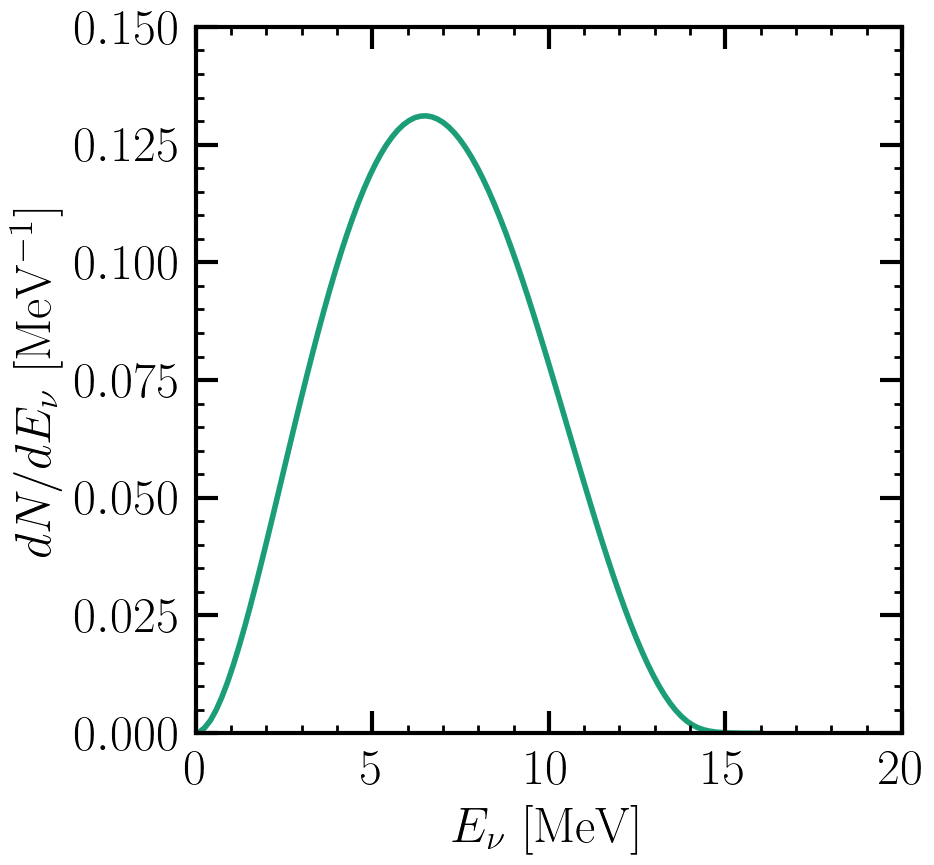

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(figsize, figsize),dpi=dpi)
ax.set_xlabel(r'$E_\nu$ [MeV]')
ax.set_ylabel(r'$dN/dE_\nu$ [MeV$^{-1}$]')
ax.plot(neutrino_energies,decay_spectrum,lw=2,ls='solid')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlim(0,20)
ax.set_ylim(0,0.15)
ax.tick_params(axis='both', pad=6)
plt.tight_layout()
ax.set_box_aspect(1)
plt.show()

The y-axis represents "the probability of a neutrino being emitted in a given energy range". Above, the spectrum has been interpolated to appear continuous for demonstration.

The differential scattering cross section can be thought of as a correlation function that maps the incoming neutrino onto a distribution of possible outgoing scattered electrons. Differential scattering cross sections for charged and neutral leptons are calculated from lengthy formulae given in the Appendices of https://arxiv.org/pdf/astro-ph/9502003, which have been converted to Python functions and can be called from <code>solarLMAO.py</code>.

As an example, the differential scattering cross section for a 10 MeV electron neutrino and an electron is plotted below. The spectrum cuts off at the kinematic limit of

$$
T_\mathrm{e} = \frac{2E_\nu^2}{2E_\nu + m_\mathrm{e}} \approx 9.75 \text{ MeV}
$$

In [5]:
neutrino_energy = 10 * u.MeV
electron_energies = np.linspace(0.1, 12, 200) * u.MeV
kinematic_limit = (2*neutrino_energy**2)/(2*neutrino_energy + sLMAO.m_electron)
flavor = 'e'

dSigma_dT = []

for T in electron_energies:
    dSigma_dT.append(sLMAO.dSigma_dT_corrections(flavor, neutrino_energy, T))

dSigma_dT = np.array(dSigma_dT)

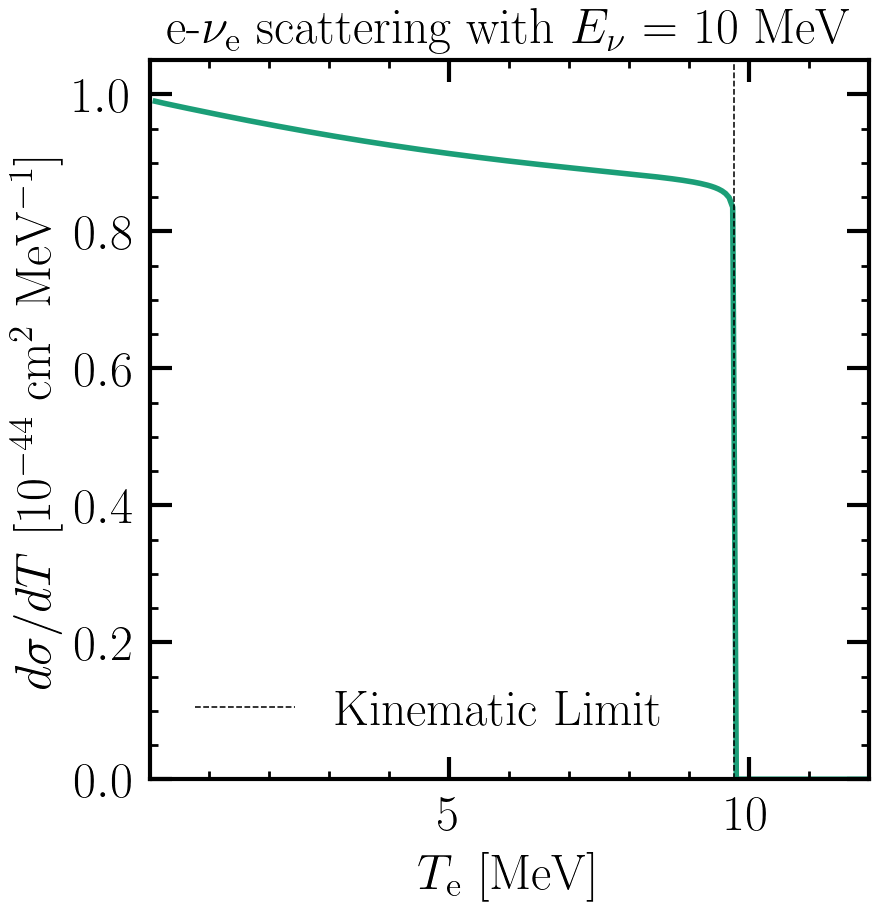

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(figsize, figsize),dpi=dpi)
ax.set_xlabel(r'$T_\mathrm{e}$ [MeV]')
ax.set_ylabel(r'$d\sigma/dT$ [$10^{-44}$ cm$^2$ MeV$^{-1}$]')
ax.plot(electron_energies,dSigma_dT * 1e44,lw=2,ls='solid')
ax.vlines(kinematic_limit.value, 0, 1.05, ls='dashed',color='k',label='Kinematic Limit')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylim(0,1.05)
ax.set_xlim(1e-2,12)
ax.tick_params(axis='both', pad=6)
ax.set_title(r'e-$\nu_\mathrm{e}$ scattering with $E_\nu$ = 10 MeV')
ax.legend()
plt.tight_layout()
ax.set_box_aspect(1)
plt.show()

In our paper, differential scattering cross sections are used for all flavors. The following block of code will generate files containing $d\sigma/dT$ for a grid of neutrino and electron energies. <b>This was not optimized for efficiency in mind, and took 45 minutes to complete on my machine. Only update the following cell to true if you intend to generate all new cross sections.</b> 

In [7]:
regenerate_cross_sections = False

In [8]:
if regenerate_cross_sections == True:
    electron_energies = np.linspace(0.1,25, sLMAO.num_points) #MeV 
    neutrino_energies = np.linspace(0.5, 30, sLMAO.num_points) #MeV
    
    print("Computing cross sections...")
    differential_cross_sections_e = np.array([[sLMAO.dSigma_dT_corrections('e',E_nu*u.MeV,T*u.MeV) for E_nu in neutrino_energies] for T in electron_energies])
    differential_cross_sections_mu_tau = np.array([[sLMAO.dSigma_dT_corrections('mu/tau',E_nu*u.MeV,T*u.MeV) for E_nu in neutrino_energies] for T in electron_energies])
    
    print("Done!")
    print("Verifying that cross sections are all non-negative...")
    for differential_cross_sections in [differential_cross_sections_e, differential_cross_sections_mu_tau]:
        for xsection in differential_cross_sections:
            for x in xsection:
                if x < 0:
                    raise ValueError("Negative cross section! :(")
    print("Saving cross sections to file...")
    
    df_differential_cross_sections_e = pd.DataFrame(differential_cross_sections_e, index=electron_energies, columns=neutrino_energies)
    df_differential_cross_sections_e.to_csv('data/differential_cross_sections_e.csv')
    df_differential_cross_sections_mu_tau = pd.DataFrame(differential_cross_sections_mu_tau, index=electron_energies, columns=neutrino_energies)
    df_differential_cross_sections_mu_tau.to_csv('data/differential_cross_sections_mu_tau.csv')
    
    print("Cross sections saved to file.")

And finally, the calculation. The following block prints, in full, the lines of code from <code>solarLMAO.py</code> which generate $R(\mathcal{T})$.

In [9]:
lines = inspect.getsource(sLMAO.generateSpectrum)
print(lines)

def generateSpectrum(beta,doMixing):
	"""
	Returns the true theory spectrum of scattered electrons in Super-K due to 8B neutrinos produced
	in the solar core, sans unitful prefactors.

		Parameters:
			beta (float): Temperature scaling parameter controlling the neutrino production zone.

			doMixing (boolean): Whether or not to introduce neutrino mixing physics while calculating 
								the spectrum of scattered electrons. 

								If False, survival probabilities are set to unity for all neutrino 
								energies, and the choice of beta does not enter.

								If True, survival probabilities are calculated using the MSW effect 
								and reactor mixing parameters given by KamLAND. The choice of beta
								will change the neutrino production zone and thus probabilities.

		Returns:
			rates (numpy.ndarray): 1D array containing the true theory spectrum.


	"""
	zone = generate_production_zone(beta)

	if doMixing == True:
		zone = generate_production_zone(beta)
		probabilities = 

In [10]:
theory_spectrum = sLMAO.generateSpectrum(beta = 0, doMixing = False)

We'll now plot this multiplied by the unitful factors to see what the spectrum of recoil electrons in Super-K looks like in the absence of neutrino mixing, finite energy resolution, and detector effects. We'll call the unitful factor

$$
u \equiv \frac{86400 \times 7.521 \times 10^{23}}{22.5 \text{ kton}} \text{day$^{-1}$},
$$

see <code>solarLMAO.py</code> for details.

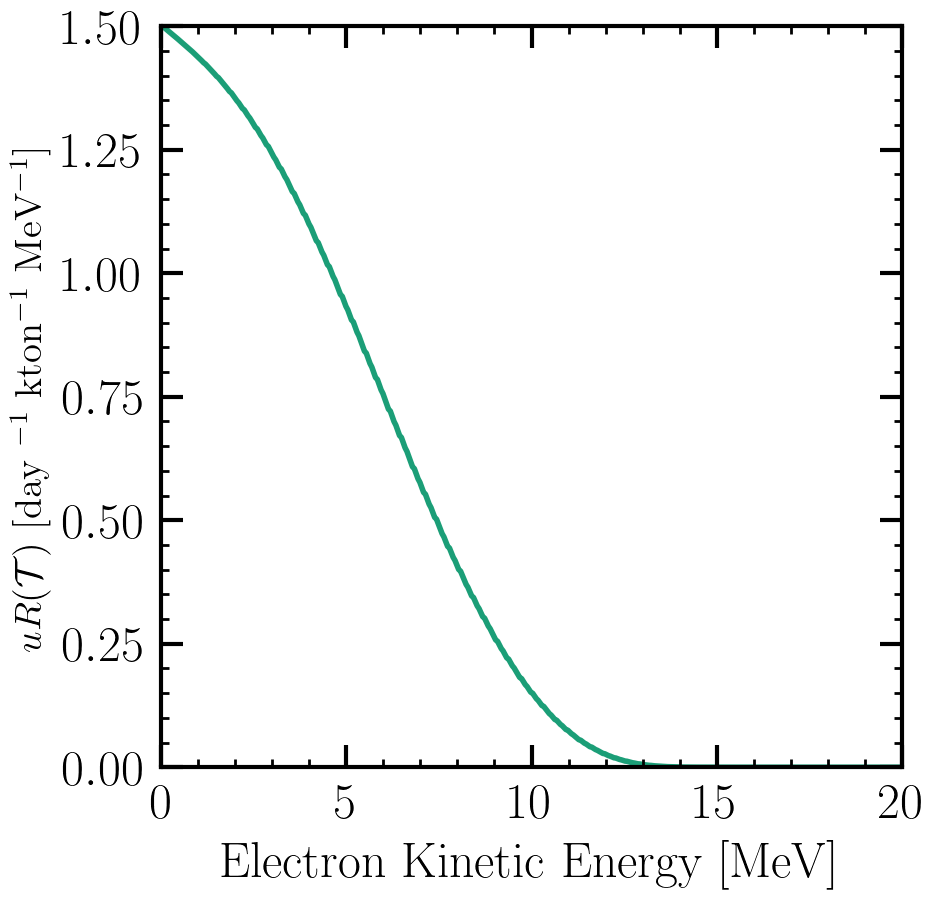

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(figsize, figsize),dpi=dpi)
ax.set_xlabel(r'Electron Kinetic Energy [MeV]')
ax.set_ylabel(r'$u R(\mathcal{T})$ [day $^{-1}$ kton$^{-1}$ MeV$^{-1}$]',fontsize=14)
ax.plot(sLMAO.recoil_energies,theory_spectrum * sLMAO.unit_factor,lw=2,ls='solid')
ax.set_ylim(0, 1.5)
ax.set_xlim(0,20)
#ax.set_ylim(1e-5,0.2)
ax.tick_params(axis='both', pad=6)
plt.tight_layout()
ax.set_box_aspect(1)
plt.show()

To compare this this "theory" spectrum with the effects of energy resolution and binning, we'll go forward plotting the spectra on log-log plots. The large range on the y-axis is helpful for observing the cutoff of the $^8$B spectrum.

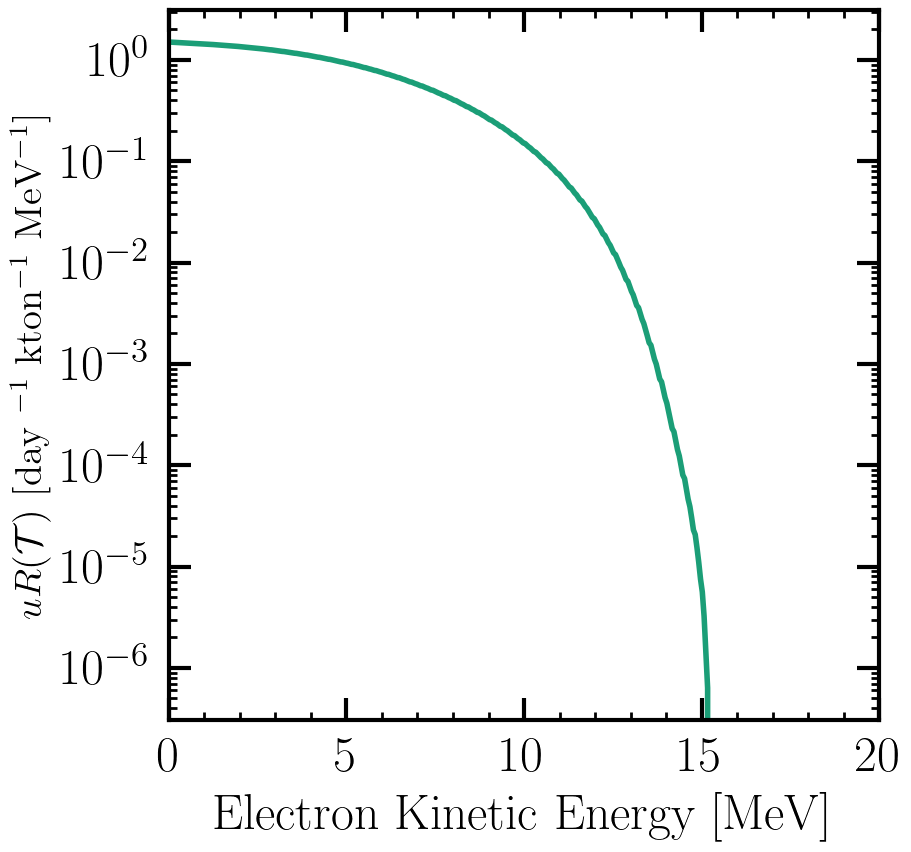

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(figsize, figsize),dpi=dpi)
ax.set_xlabel(r'Electron Kinetic Energy [MeV]')
ax.set_ylabel(r'$u R(\mathcal{T})$ [day $^{-1}$ kton$^{-1}$ MeV$^{-1}$]',fontsize=14)
ax.plot(sLMAO.recoil_energies,theory_spectrum * sLMAO.unit_factor,lw=2,ls='solid')
ax.set_yscale('log')
ax.set_xlim(0,20)
#ax.set_ylim(1e-5,0.2)
ax.tick_params(axis='both', pad=6)
plt.tight_layout()
ax.set_box_aspect(1)
plt.show()

# Electron spectrum accounting for finite energy resolution

To account for energy resolution effects in Super-K, $R(\mathcal{T})$ is passed into

$$
S(\mathcal{T}) = \int_{{T_{\mathrm{e,min}}}}^{{T_\mathrm{e,max}}} dT_\mathrm{e} G(T_\mathrm{e},\mathcal{T},\sigma(\mathcal{T})) R(\mathcal{T})
$$

where
* $T_\mathrm{e}$ is the measured kinetic energy
* the limits of integration are chosen to eliminate energy-resolution-induced smoothing effects on the edges of the spectrum,
* $G(T_\mathrm{e},\mathcal{T},\sigma(\mathcal{T})) = \frac{1}{\sigma(\mathcal{T})\sqrt{2\pi}} \times \exp\left[-\frac{(\mathcal{T} - T_\mathrm{e})^2}{2(\sigma(\mathcal{T}))^2}\right],$ with
* $\sigma(\mathcal{T}) = -0.5525 + 0.3162\sqrt{\mathcal{T}+ \mathrm{m}_\mathrm{e}} + 0.04572(\mathcal{T} + m_\mathrm{e})$

The relevant Python functions for calculating $S(\mathcal{T})$ are

In [13]:
func_list = [sLMAO.smear_numeric_sampled, sLMAO.resolvingGaussian, sLMAO.resolution]
for function in func_list:
    lines = inspect.getsource(function)
    print(lines)

def smear_numeric_sampled(true_spectrum,true_energies):
	"""
	Returns a spectrum of scattered electrons accounting for effects due to energy resolution
	given a true spectrum.

		Parameters:
			true_spectrum (numpy.ndarray): 1D array containing the "continuous" true spectrum.

			true_energies (numpy.ndarray): 1D array containing the true energies along which the
										   true spectrum is defined.

		Returns:
			measured_rates (numpy.ndarray): 1D array containing the calculated measured spectrum
											after taking into account energy resolution effects.
	"""
	measured_energies = np.array(true_energies,copy=True)
	measured_rates = []
	for T_measured in measured_energies:
		G = resolvingGaussian(T_measured,true_energies)
		integrand = true_spectrum * G
		sol = sp.integrate.simpson(integrand,true_energies)
		measured_rates.append(sol)

	return np.array(measured_rates)

def resolvingGaussian(T_measured,T_true):
	"""
	Returns a Gaussian window for use in applying the effects of ene

The continuous electron recoil spectrum in the presence of finite energy resolution is computed and plotted below:

In [14]:
resolved_spectrum = sLMAO.smear_numeric_sampled(theory_spectrum, sLMAO.recoil_energies)

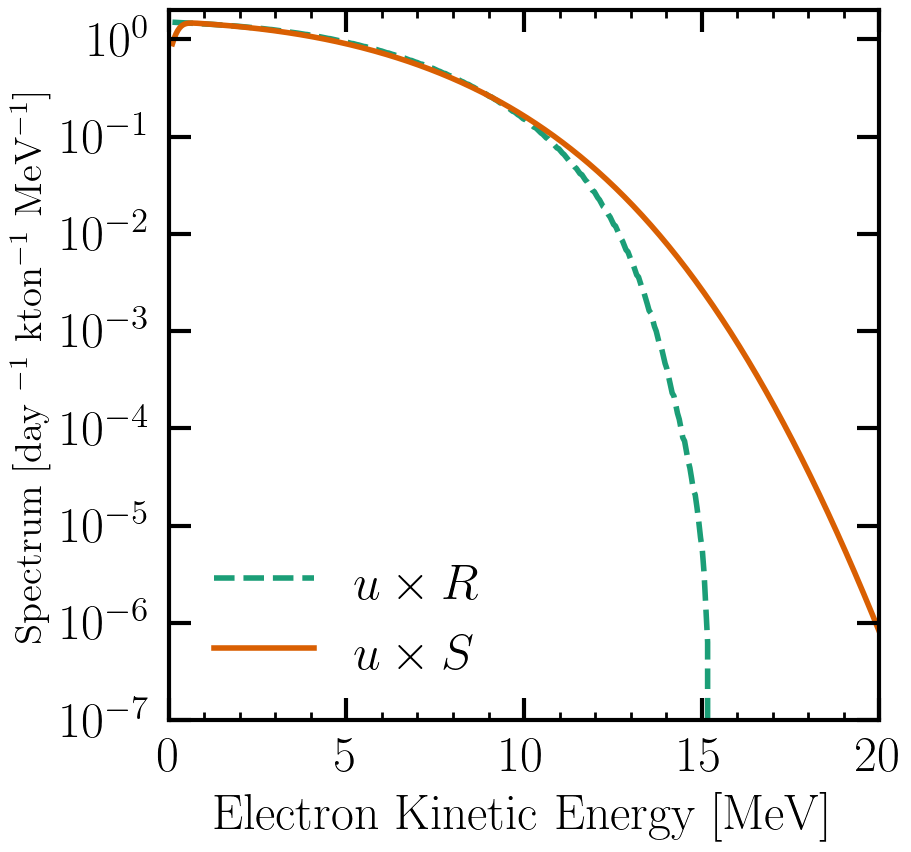

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(figsize, figsize),dpi=dpi)
ax.set_xlabel(r'Electron Kinetic Energy [MeV]')
ax.set_ylabel(r'Spectrum [day $^{-1}$ kton$^{-1}$ MeV$^{-1}$]',fontsize=14)
ax.plot(sLMAO.recoil_energies,theory_spectrum * sLMAO.unit_factor,lw=2,ls='dashed',label=r'$u \times R$')
ax.plot(sLMAO.recoil_energies,resolved_spectrum * sLMAO.unit_factor,lw=2,ls='solid',label=r'$u \times S$')
ax.set_yscale('log')
ax.set_yticks([1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1])
ax.set_xlim(0,20)
ax.set_ylim(1e-7,2)
ax.tick_params(axis='both', pad=6)
ax.legend()
plt.tight_layout()
ax.set_box_aspect(1)
plt.show()

# Binned electron spectrum

The final operation on the electron spectrum is binning according to the Super-K energy bins. This is accomplished and labeled in the paper as

$$
\left(\frac{\Delta N}{\Delta T} \right)_i = \frac{\mathrm{N}_\mathrm{e}}{\mathrm{M}_\mathrm{det}\Delta T_i} \int_{T_i^\mathrm{left}+\delta}^{T_i^\mathrm{left} + \Delta T_i +\delta} d\mathcal{T} S(\mathcal{T}),
$$

where
* $\Delta T_i$ is the width of the $i^\mathrm{th}$ Super-K kinetic energy bin
* $T_i^{\mathrm{left}}$ is the left edge of the bin
* $\delta$ is uncertainty in the absolute energy scale of the detector, which we set to zero for simplicity,
* $\mathrm{N}_\mathrm{e} = 7.521 \times 10^{33}$ is the number of electrons in the Super-K detector volume
* $\mathrm{M}_\mathrm{det} = 22.5$ kton is the total mass of water in the Super-K detector volume

There is an implicit factor of 86,400 for the conversion from seconds to days which is not shown here, but is included in the computation. To be explicit, one may instead label this computation as 

$$
\left(\frac{\Delta N}{\Delta T} \right)_i = u\frac{1}{\Delta T_i} \int_{T_i^\mathrm{left}+\delta}^{T_i^\mathrm{left} + \Delta T_i +\delta} d\mathcal{T} S(\mathcal{T}),
$$

which will be plotted below.

The relevant Python function for this computation is

In [16]:
lines = inspect.getsource(sLMAO.discretize)
print(lines)

def discretize(recoil_energies, measured_rates):
	"""
	Returns the discretized scattered electron spectrum after energy resolution
	effects, binned according to Super-K's data presentation.

		Parameters:
			recoil_energies (numpy.ndarray): 1D array containing measured electron kinetic 
											 energies in imlicit units of MeV.

			measured_rates (numpy.ndarray): 1D array containing the calculated measured spectrum
											after taking into account energy resolution effects.

		Returns:
			discrete_rates (numpy.ndarray): 1D array containing the discretized electron spectrum
	"""
	rate_interp = sp.interpolate.interp1d(recoil_energies, measured_rates)
	discrete_rates = []
	delta = 0
	for i, energy in enumerate(SK_bin_left):
		sol = sp.integrate.romberg(rate_interp, energy+delta,energy+SK_widths[i]+delta) /SK_widths[i]
		discrete_rates.append(sol)
	return np.array(discrete_rates)



In [17]:
final_spectrum = sLMAO.discretize(sLMAO.recoil_energies,resolved_spectrum) * sLMAO.unit_factor

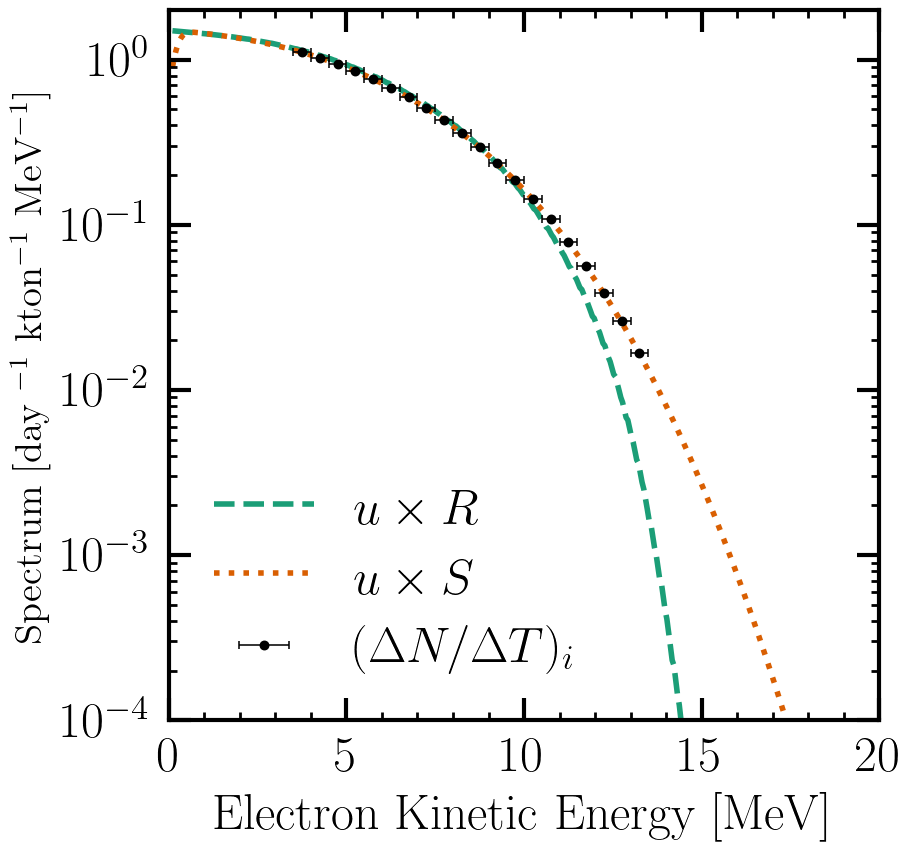

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(figsize, figsize),dpi=dpi)
ax.set_xlabel(r'Electron Kinetic Energy [MeV]')
ax.set_ylabel(r'Spectrum [day $^{-1}$ kton$^{-1}$ MeV$^{-1}$]',fontsize=14)
ax.plot(sLMAO.recoil_energies,theory_spectrum * sLMAO.unit_factor,lw=2,ls='dashed',label=r'$u \times R$')
ax.plot(sLMAO.recoil_energies,resolved_spectrum * sLMAO.unit_factor,lw=2,ls='dotted',label=r'$u \times S$')
#ax.scatter(sLMAO.SK_bin_center,final_spectrum,)
ax.errorbar(sLMAO.SK_bin_center,final_spectrum, xerr = sLMAO.SK_widths/2, marker='o', markersize = 3, label=r'$(\Delta N/\Delta T)_i$',color='k', linestyle='none')

ax.set_yscale('log')
ax.set_xlim(0,20)
ax.set_ylim(1e-4,2)
ax.tick_params(axis='both', pad=6)
ax.legend()
plt.tight_layout()
ax.set_box_aspect(1)
plt.show()

# The Ratio Plot

To compare our analytical treatment of the spectrum of scattered electrons, we obtain the Super-K prediction for the spectrum from Table IX of https://arxiv.org/pdf/2312.12907. Namely, the $^8$B column under "Expected rate", taking points from 3.49--13.49 MeV:

In [19]:
SK_model = np.array([197.2,183.1,168.6,154.0,138.5,122.7,107.5,92.7,78.7,65.6,53.9,43.2,34.0,26.2,19.75,14.44,10.35,7.16,4.84,3.15])/(365*sLMAO.SK_widths)

Let's first plot the observed spectrum in Super-K along with Super-K's model and the calculation here.

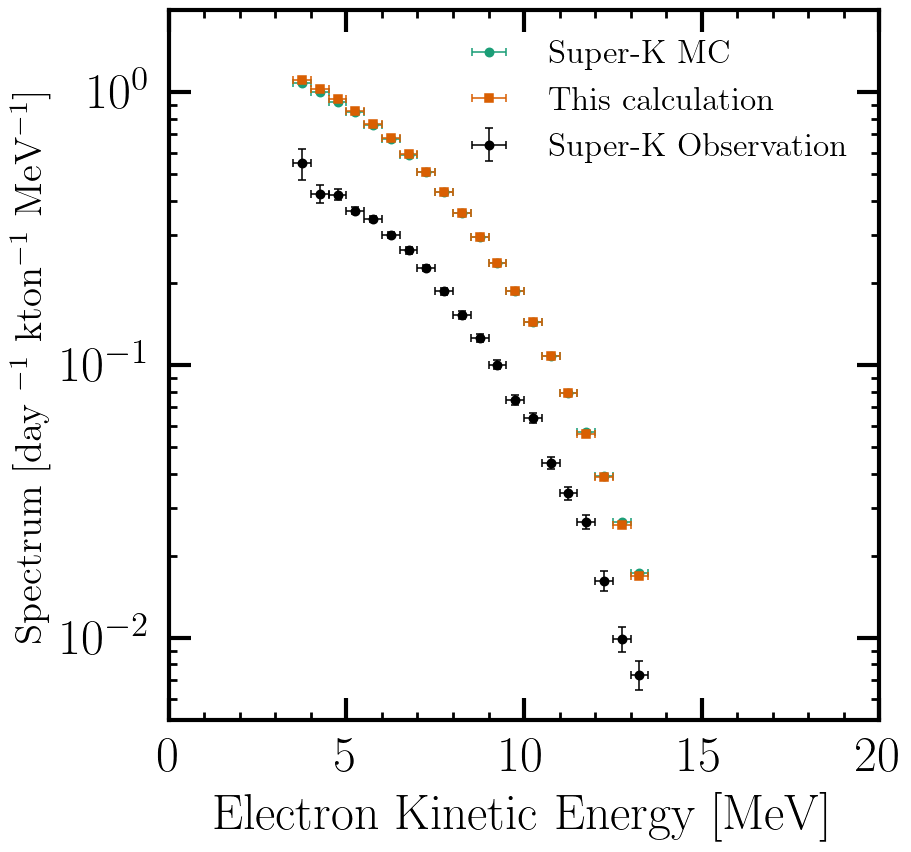

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(figsize, figsize),dpi=dpi)
ax.set_xlabel(r'Electron Kinetic Energy [MeV]')
ax.set_ylabel(r'Spectrum [day $^{-1}$ kton$^{-1}$ MeV$^{-1}$]',fontsize=14)
ax.errorbar(sLMAO.SK_bin_center,SK_model, xerr = sLMAO.SK_widths/2, marker='o', markersize = 3, label=r'Super-K MC',linestyle='none')
ax.errorbar(sLMAO.SK_bin_center,final_spectrum, xerr = sLMAO.SK_widths/2, marker='s', markersize = 3,label=r'This calculation',linestyle='none')
ax.errorbar(sLMAO.SK_bin_center,sLMAO.SK_observed, xerr = sLMAO.SK_widths/2, yerr = sLMAO.SK_err, marker='o', markersize = 3, label=r'Super-K Observation',color='k', linestyle='none')

ax.set_yscale('log')
ax.set_xlim(0,20)
ax.set_ylim(5e-3,2)
ax.tick_params(axis='both', pad=6)
ax.legend(fontsize=12)
plt.tight_layout()
ax.set_box_aspect(1)
plt.show()

We'll now divide the observed spectrum of scattered electrons (with statistical uncertainties) by both Super-K's Monte Carlo (MC) model and the model computed here as a comparison.

In [21]:
SK_ratio = sLMAO.SK_observed / SK_model
our_ratio = sLMAO.SK_observed / final_spectrum

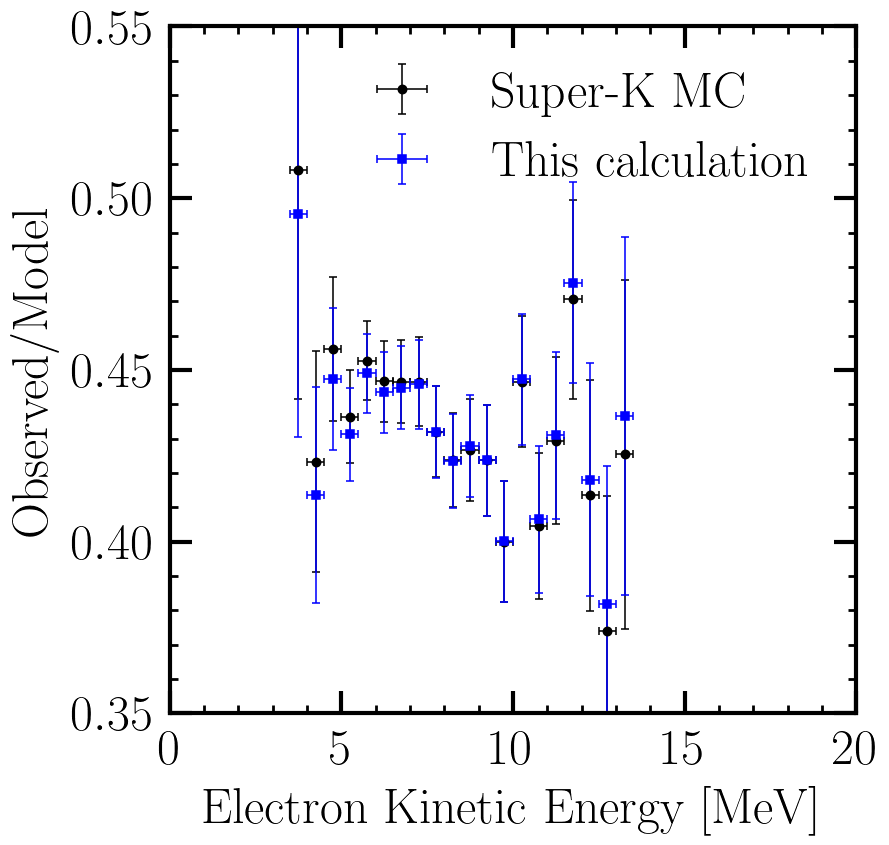

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(figsize, figsize),dpi=dpi)
ax.set_xlabel(r'Electron Kinetic Energy [MeV]')
ax.set_ylabel(r'Observed/Model')
ax.errorbar(sLMAO.SK_bin_center,SK_ratio, xerr = sLMAO.SK_widths/2, yerr = sLMAO.SK_err/SK_model, marker='o', markersize = 3, label=r'Super-K MC',color='k', linestyle='none')
ax.errorbar(sLMAO.SK_bin_center,our_ratio, xerr = sLMAO.SK_widths/2, yerr = sLMAO.SK_err/final_spectrum, marker='s', markersize = 3, label=r'This calculation',color='blue', linestyle='none')
ax.set_xlim(0,20)
ax.set_ylim(0.35,0.55)
ax.legend()
ax.tick_params(axis='both', pad=6)
plt.tight_layout()
ax.set_box_aspect(1)
plt.show()

Our calculation of the spectrum of scattered electrons due to $^8$B neutrinos in Super-K is consistent with the collaboration's MC model, well within the statistical uncertainties of the observed spectrum.

Finally, we show the ratio between our model and Super-K's:


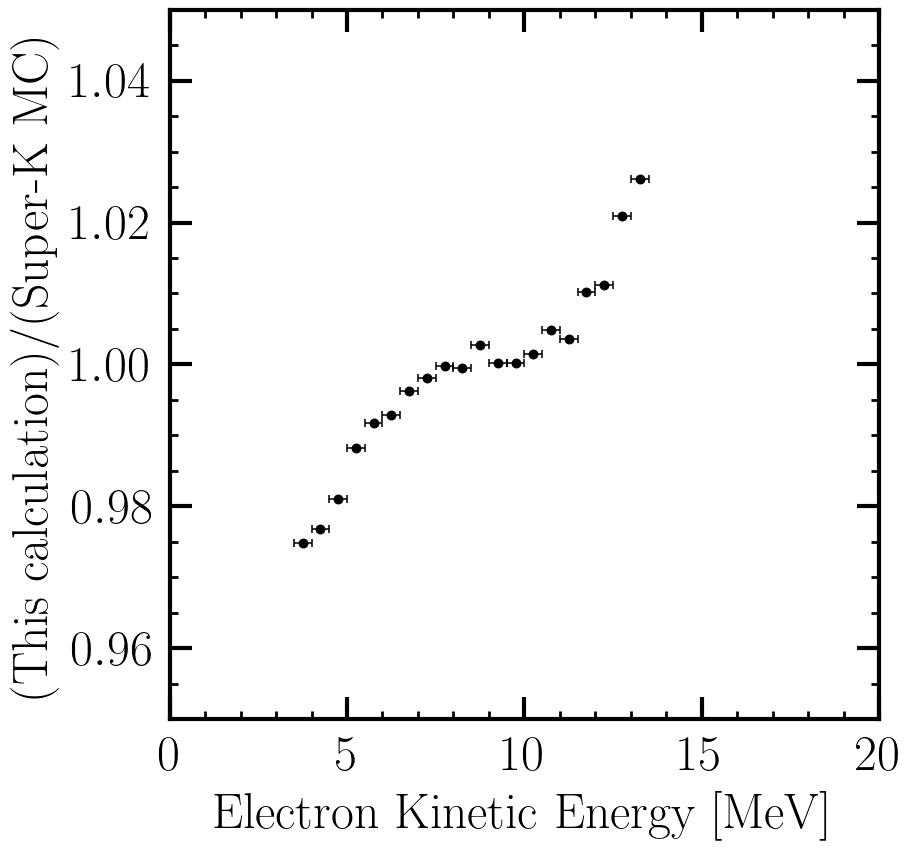

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(figsize, figsize),dpi=dpi)
ax.set_xlabel(r'Electron Kinetic Energy [MeV]')
ax.set_ylabel(r'(This calculation)/(Super-K MC)')
#ax.scatter(sLMAO.SK_bin_center,our_ratio/SK_ratio,lw=2,ls='solid')
ax.errorbar(sLMAO.SK_bin_center,our_ratio/SK_ratio, xerr = sLMAO.SK_widths/2, marker='o', markersize = 3, color='k', linestyle='none')
ax.set_xlim(0,20)
ax.set_ylim(0.95,1.05)
ax.tick_params(axis='both', pad=6)
plt.tight_layout()
ax.set_box_aspect(1)
plt.show()